# Dataset Information

# Business Problem

**Telecom companies face high customer churn rates—when subscribers leave for a competitor—which directly erodes revenue. Acquiring a new customer can cost 5× more than retaining an existing one. Our objective:**

- Predict which customers are at high risk of churning, based on their demographics, service subscriptions, and billing/usage history.

- Enable proactive retention strategies—targeted offers, personalized outreach, or service adjustments—for those high‐risk customers.

- Reduce overall churn rate, boosting customer lifetime value and stabilizing revenue.

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib

### Loading Data

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

### Basic Information about data

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [189]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [190]:
from pandas_profiling import ProfileReport

# Create a ProfileReport object
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Cleaning Data

In [7]:
# Drop the unique ID column
df.drop("customerID", axis=1, inplace=True)

In [8]:
# Convert TotalCharges to numeric, coerce errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [9]:
# Fill missing TotalCharges with the median
median_tc = df["TotalCharges"].median()
df["TotalCharges"].fillna(median_tc, inplace=True)

In [10]:
df.sample()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4492,Male,0,Yes,Yes,54,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),24.05,1230.9,No


### Data Visualisation

In [11]:
sns.set_style("whitegrid")

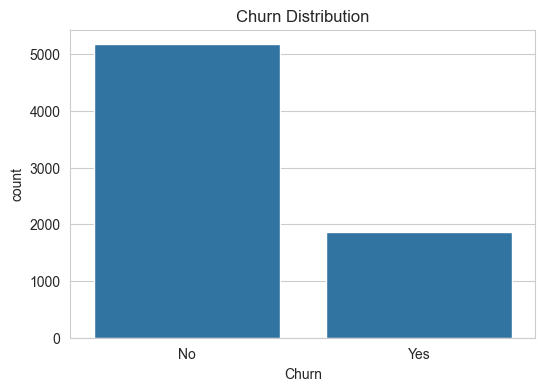

In [12]:
# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

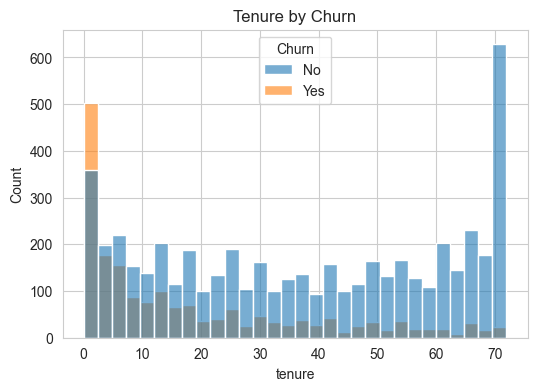

In [13]:
# Tenure by churn
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, alpha=0.6)
plt.title("Tenure by Churn")
plt.show()

`Insight`
- Customers with low tenure (new customers) are more likely to churn.
- Customers with longer tenure tend to stay loyal.

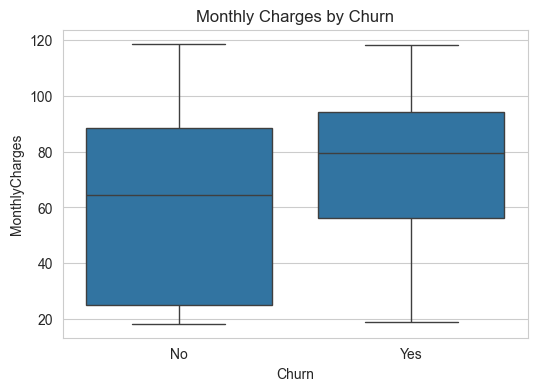

In [14]:
# Monthly charges by churn
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges by Churn")
plt.show()

`Insight`
- Customers who churned often had higher monthly charges.
- This could mean people who pay more are more sensitive and leave if they don’t feel value for money.



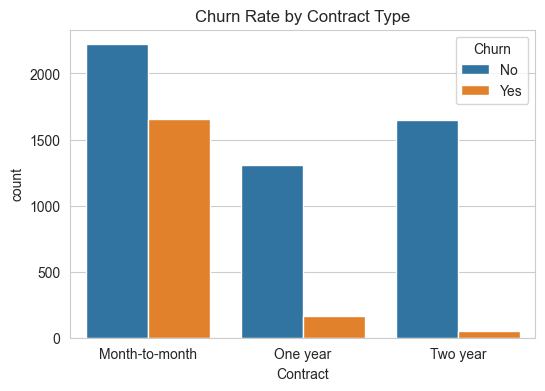

In [15]:
# Contract Type VS Churn
plt.figure(figsize=(6,4))
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn Rate by Contract Type")
plt.show()

`Insight`
- Customers on month-to-month contracts are far more likely to churn than those on 1 or 2-year contracts. Longer contracts increase customer retention.

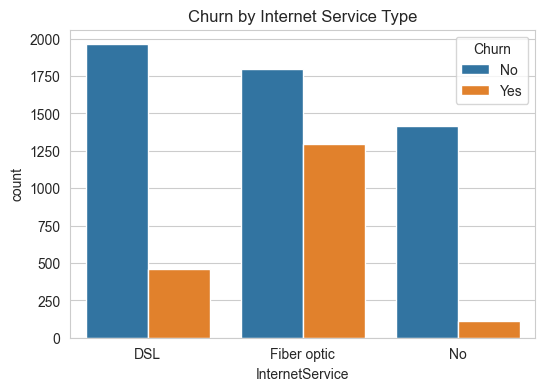

In [16]:
# Internet service type vs churn
plt.figure(figsize=(6,4))
sns.countplot(x="InternetService", hue="Churn", data=df)
plt.title("Churn by Internet Service Type")
plt.show()


`Insight`:
- Customers using Fiber optic internet are more likely to churn than those using DSL or No internet. Maybe because fiber optic is more expensive or less reliable.

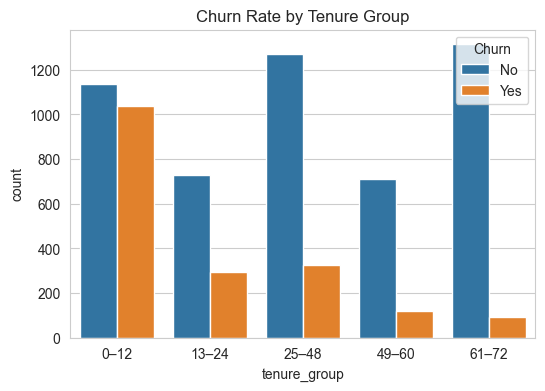

In [17]:
# Creting diffrent tenure groups
df["tenure_group"] = pd.cut(df["tenure"], bins=[0, 12, 24, 48, 60, 72], labels=["0–12","13–24","25–48","49–60","61–72"])

# tenure group vs churn
plt.figure(figsize=(6,4))
sns.countplot(x="tenure_group", hue="Churn", data=df)
plt.title("Churn Rate by Tenure Group")
plt.show()

`Insight`
- Most churn happens in the first 12 months. Retention efforts should focus here.

### Data Preprocessing

In [18]:
# Map binary columns
binary_map = {"Yes": 1, "No": 0, "Female": 1, "Male": 0}
df["gender"]        = df["gender"].map(binary_map)
df["Partner"]       = df["Partner"].map(binary_map)
df["Dependents"]    = df["Dependents"].map(binary_map)
df["PhoneService"]  = df["PhoneService"].map(binary_map)
df["PaperlessBilling"] = df["PaperlessBilling"].map(binary_map)
df["Churn"]         = df["Churn"].map(binary_map)

In [19]:
df.sample()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
2695,0,0,1,0,52,1,Yes,DSL,Yes,Yes,...,Yes,No,Yes,One year,1,Credit card (automatic),81.4,4354.45,0,49–60


In [20]:
df["MultipleLines"].unique()

array(['No phone service', 'No', 'Yes'], dtype=object)

In [21]:
# Handle "No phone service" in MultipleLines
df["MultipleLines"] = df["MultipleLines"].replace({"No phone service": "No"}).map(binary_map)

In [22]:
# One-hot encode remaining categorical features
to_encode = [
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"
]

In [23]:
df = pd.get_dummies(df, columns=to_encode, drop_first=True)

In [24]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,1,29.85,29.85,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,0,34,1,0,0,56.95,1889.50,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,0,2,1,0,1,53.85,108.15,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,0,45,0,0,0,42.30,1840.75,...,True,False,False,False,False,True,False,False,False,False
4,1,0,0,0,2,1,0,1,70.70,151.65,...,False,False,False,False,False,False,False,False,True,False


In [25]:
# Scale numerical features
scaler = StandardScaler()
for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    df[col] = scaler.fit_transform(df[[col]])

In [26]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,-1.277445,0,0,1,-1.160323,-0.994242,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,0,0.066327,1,0,0,-0.259629,-0.173244,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,0,-1.236724,1,0,1,-0.362660,-0.959674,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,0,0.514251,0,0,0,-0.746535,-0.194766,...,True,False,False,False,False,True,False,False,False,False
4,1,0,0,0,-1.236724,1,0,1,0.197365,-0.940470,...,False,False,False,False,False,False,False,False,True,False


### Model Training

In [27]:
# Trai-test split

X = df.drop(["Churn", "tenure_group"], axis=1)
y = df["Churn"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


In [30]:
# rf = RandomForestClassifier(class_weight="balanced", random_state=42)

In [31]:
# param_grid = {
#     "n_estimators": [100, 200],
#     "max_depth": [None, 10, 20],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2],
#     "bootstrap": [True, False],
# }

In [32]:
# grid = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,scoring="roc_auc",
#     n_jobs=-1,verbose=1)

In [33]:
# grid.fit(X_resampled, y_resampled)

In [34]:
# best_rf = grid.best_estimator_
# print("Best hyperparameters:", grid.best_params_)

In [35]:
# y_pred = best_rf.predict(X_test)
# y_proba = best_rf.predict_proba(X_test)[:, 1]

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

In [36]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [37]:
results = []

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC AUC": roc
    })

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [38]:
results_df = pd.DataFrame(results).sort_values("F1-Score", ascending=False)

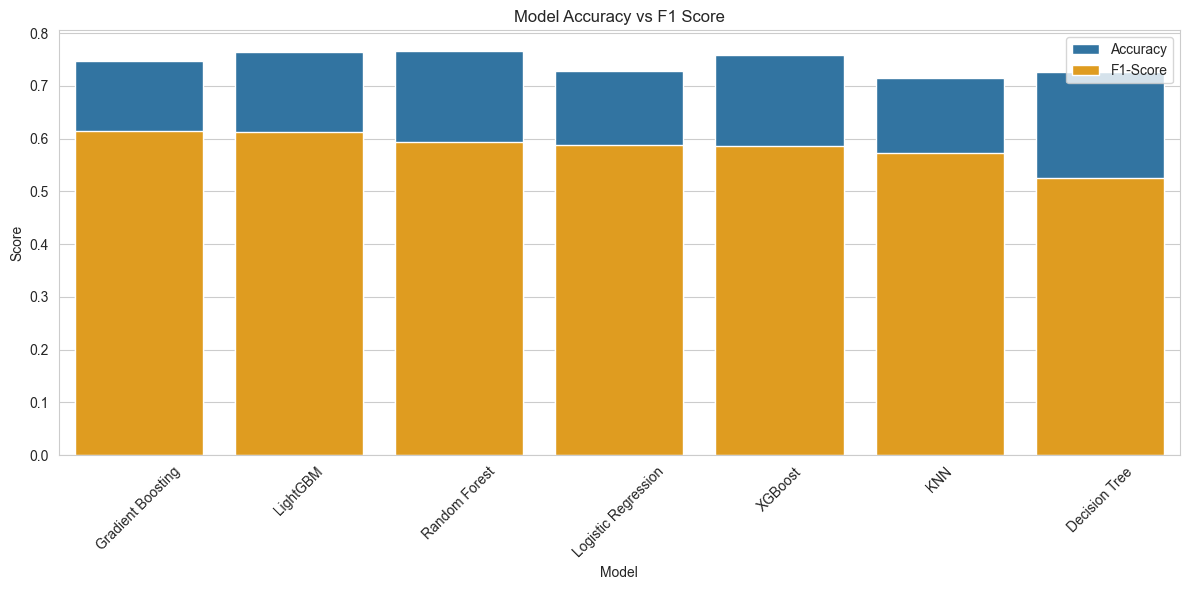

In [39]:
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, label="Accuracy")
sns.barplot(x="Model", y="F1-Score", data=results_df, label="F1-Score", color="orange")
plt.title("Model Accuracy vs F1 Score")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
print("\n📊 Model Comparison:")
print(results_df.to_string(index=False))


📊 Model Comparison:
              Model  Accuracy  F1-Score  ROC AUC
  Gradient Boosting  0.746629  0.614887 0.835879
           LightGBM  0.763662  0.613240 0.826431
      Random Forest  0.767211  0.593052 0.818460
Logistic Regression  0.728886  0.587473 0.821920
            XGBoost  0.757984  0.585662 0.807417
                KNN  0.716111  0.573561 0.781668
      Decision Tree  0.726757  0.526445 0.677194


`Insight`
- We can see that Gradient Boosting is the best model in this case. Both F1-score & ROC AUC is best for this case.

In [46]:
##### Hyperparameter tuning 
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(gb,param_grid,cv=5,scoring='roc_auc',n_jobs=-1, verbose=1)
grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [47]:
best_model = grid.best_estimator_
print("Best Hyperparameters:", grid.best_params_)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


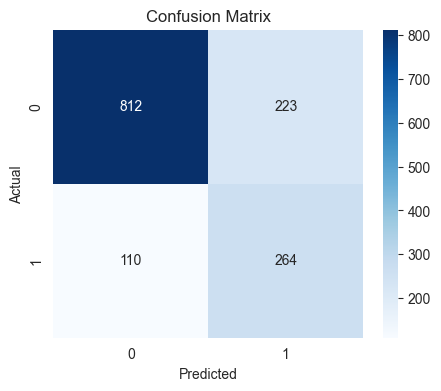

In [48]:
# # Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

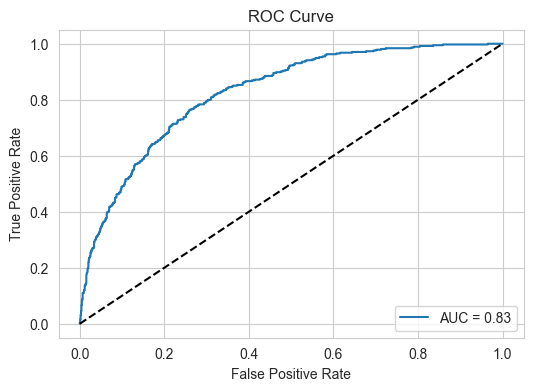

In [49]:
# # ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [44]:
# joblib.dump(best_rf, "churn_model.pkl")
# joblib.dump(scaler, "scaler.pkl")
# print("Model saved to churn_model.pkl")
# print("Scaler saved to scaler.pkl")

In [50]:
joblib.dump(best_model, "best_churn_model.pkl")
print("Gradient Boosting model saved!")

Gradient Boosting model saved!
